In [14]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import netCDF4 as nc

#------------------------------------------------------------------------------
# File paths – adjust these to your environment
#------------------------------------------------------------------------------
input_path = r"D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\lake_statistics.csv"
output_path = r"D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\lake_statistics.nc"

#------------------------------------------------------------------------------
# Define ID columns and the 9 metrics
#------------------------------------------------------------------------------
id_vars = ["lake_id", "area", "perimeter"]
metrics = [
    "total_pixels", "usable_pixels", "clear_percent",
    "ice_pixels", "ice_percent", "snow_pixels",
    "snow_percent", "water_pixels", "water_percent"
]

#------------------------------------------------------------------------------
# Regex pattern to parse columns
#------------------------------------------------------------------------------
pattern = re.compile(
    r"^(\d{8}_\d{6}_.*)_(" + "|".join(metrics) + r")$"
)

def parse_col(col_name):
    """
    Returns (prefix, metric) if the column name matches, else (None, None).
    """
    m = pattern.match(col_name)
    if m:
        return m.group(1), m.group(2)
    return None, None

def parse_time_from_prefix(prefix):
    """
    Extracts a datetime object from a prefix.
    """
    m = re.match(r"^(\d{8})_(\d{6})", prefix)
    if m:
        dt_str = m.group(1) + m.group(2)
        return datetime.strptime(dt_str, "%Y%m%d%H%M%S")
    return None

#------------------------------------------------------------------------------
# Read the CSV file
#------------------------------------------------------------------------------
df = pd.read_csv(input_path)

#------------------------------------------------------------------------------
# Process each lake (each row) to collect its image data
#------------------------------------------------------------------------------
lake_data = {}

for idx, row in df.iterrows():
    lake_id = row["lake_id"]
    lake_area = row["area"]
    lake_perimeter = row["perimeter"]
    images = {}  # key: prefix, value: dict of metrics

    # Loop over all non-ID columns:
    for col in df.columns:
        if col in id_vars:
            continue
        prefix, metric = parse_col(col)
        if prefix is None:
            continue  # Skip columns that do not match the pattern
        val = row[col]
        if pd.isna(val):
            continue  # Skip missing values
        if prefix not in images:
            images[prefix] = {}
        images[prefix][metric] = val

    # Sort the valid image entries by timestamp
    sorted_prefixes = sorted(images.keys(), key=lambda p: parse_time_from_prefix(p))
    
    # Prepare time series data
    time_series = []
    for p in sorted_prefixes:
        dt = parse_time_from_prefix(p)
        timestamp = dt.timestamp() if dt is not None else np.nan
        
        # Prepare metrics for this image
        image_metrics = {"timestamp": timestamp, "prefix": p}
        for m in metrics:
            image_metrics[m] = images[p].get(m, np.nan)
        
        time_series.append(image_metrics)
    
    lake_data[lake_id] = {
        "area": lake_area,
        "perimeter": lake_perimeter,
        "image_count": len(sorted_prefixes),
        "time_series": time_series
    }

# NetCDF Export
ncfile = nc.Dataset(output_path, 'w', format='NETCDF4')

# Determine max number of images across all lakes
max_images = max(len(data['time_series']) for data in lake_data.values())

# Create dimensions
ncfile.createDimension('lake', len(lake_data))
ncfile.createDimension('time_series', max_images)

# Lake-level variables
lake_id_var = ncfile.createVariable('lake_id', 'i8', ('lake',))
area_var = ncfile.createVariable('area', 'f8', ('lake',))
perimeter_var = ncfile.createVariable('perimeter', 'f8', ('lake',))
image_count_var = ncfile.createVariable('image_count', 'i8', ('lake',))

# Time series variables
timestamps_var = ncfile.createVariable('timestamps', 'f8', ('lake', 'time_series'), fill_value=np.nan)
prefixes_var = ncfile.createVariable('prefixes', str, ('lake', 'time_series'), fill_value='')

# Metric variables for time series
metric_vars = {}
for m in metrics:
    metric_vars[m] = ncfile.createVariable(m, 'f8', ('lake', 'time_series'), fill_value=np.nan)

# Write data
for i, (lake_id, data) in enumerate(lake_data.items()):
    # Lake-level data
    lake_id_var[i] = lake_id
    area_var[i] = data['area']
    perimeter_var[i] = data['perimeter']
    image_count_var[i] = data['image_count']
    
    # Time series data
    for j, entry in enumerate(data['time_series']):
        timestamps_var[i, j] = entry['timestamp']
        prefixes_var[i, j] = entry['prefix']
        
        # Write metrics for each image
        for m in metrics:
            metric_vars[m][i, j] = entry[m]

ncfile.close()
print(f"\nNetCDF file created at: {output_path}")
print(f"Total lakes processed: {len(lake_data)}")
print(f"Maximum images per lake: {max_images}")


NetCDF file created at: D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\lake_statistics.nc
Total lakes processed: 43929
Maximum images per lake: 14


In [4]:
import netCDF4 as nc
import numpy as np
import pandas as pd

def check_lake_data(netcdf_path, lake_id=None):
    """
    Read and display lake data from a NetCDF file.
    
    Parameters:
    -----------
    netcdf_path : str
        Path to the NetCDF file
    lake_id : int, optional
        Specific lake ID to inspect. If None, lists all lake IDs.
    """
    # Open the NetCDF file
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        # Get all lake IDs
        lake_ids = ncfile.variables['lake_id'][:]
        
        # If no specific lake_id is provided, list all lake IDs
        if lake_id is None:
            print("Available Lake IDs:")
            for idx, lid in enumerate(lake_ids):
                print(f"Index {idx}: Lake ID {lid}")
            return
        
        # Find the index of the specified lake
        try:
            lake_index = np.where(lake_ids == lake_id)[0][0]
        except IndexError:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return
        
        # Print lake-level metadata
        print(f"\nLake ID: {lake_id}")
        print(f"Area: {ncfile.variables['area'][lake_index]:.2f}")
        print(f"Perimeter: {ncfile.variables['perimeter'][lake_index]:.2f}")
        print(f"Number of Images: {ncfile.variables['image_count'][lake_index]}")
        
        # Prepare to extract time series data
        metrics = [
            'total_pixels', 'usable_pixels', 'clear_percent',
            'ice_pixels', 'ice_percent', 'snow_pixels',
            'snow_percent', 'water_pixels', 'water_percent'
        ]
        
        # Create a DataFrame to display time series data
        timestamps = ncfile.variables['timestamps'][lake_index]
        prefixes = ncfile.variables['prefixes'][lake_index]
        
        # Prepare data for DataFrame
        data = {
            'Timestamp': timestamps,
            'Prefix': prefixes
        }
        
        # Add metrics to data 
        for metric in metrics:
            data[metric] = ncfile.variables[metric][lake_index]
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Remove rows with NaN timestamps (padding)
        df = df[~pd.isna(df['Timestamp'])]
        
        # Convert timestamp to datetime
        df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='s')
        
        # Reorder and display
        columns = ['Datetime', 'Prefix'] + metrics
        print("\nTime Series Data:")
        print(df[columns].to_string(index=False))

In [5]:
# Replace with the path to your NetCDF file
netcdf_path = r"D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\lake_statistics.nc"

# To check a specific lake (uncomment and replace with desired lake ID)
check_lake_data(netcdf_path, lake_id=674813)


Lake ID: 674813
Area: nan
Perimeter: nan
Number of Images: 4

Time Series Data:
           Datetime                                   Prefix  total_pixels  usable_pixels  clear_percent  ice_pixels  ice_percent  snow_pixels  snow_percent  water_pixels  water_percent
2023-05-08 01:08:32 20230507_210832_51_2482_3B_AnalyticMS_SR      181242.0       181242.0          100.0     19499.0    10.758544     161743.0     89.241456           0.0       0.000000
2023-05-13 00:33:04 20230512_203304_26_24ca_3B_AnalyticMS_SR      181242.0       181242.0          100.0    117303.0    64.721753      63384.0     34.972026         555.0       0.306220
2023-05-13 01:07:38 20230512_210738_61_241c_3B_AnalyticMS_SR      181242.0       181242.0          100.0    130465.0    71.983867      50238.0     27.718741         539.0       0.297392
2023-05-19 00:39:45 20230518_203945_30_24cf_3B_AnalyticMS_SR      181242.0       181242.0          100.0     65877.0    36.347535          0.0      0.000000      115365.0     

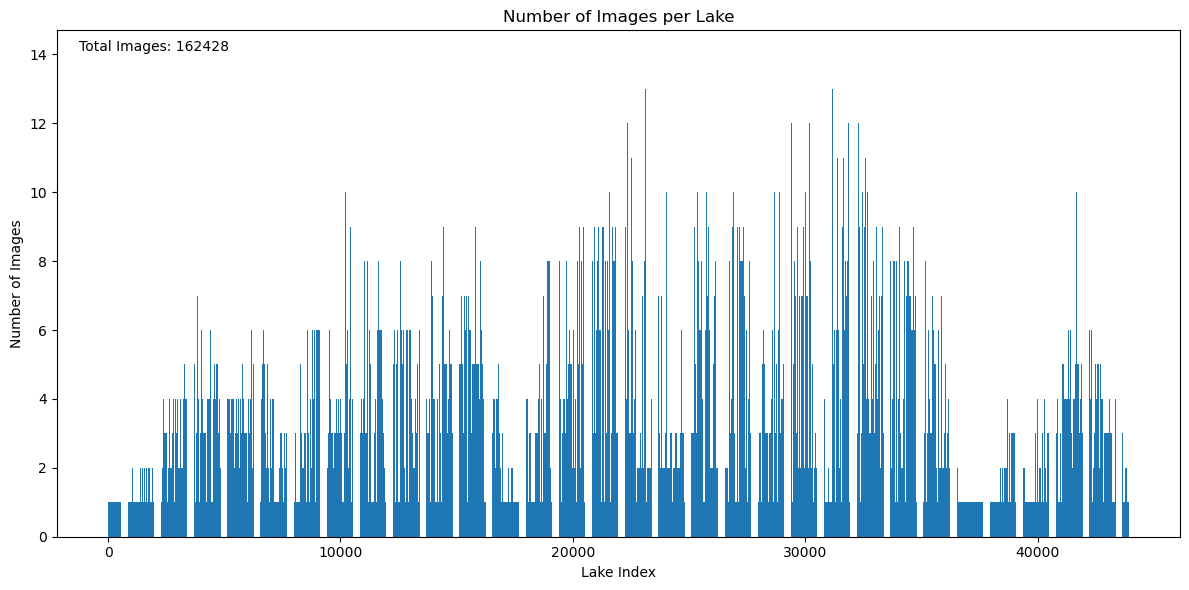

In [6]:
import netCDF4 as nc
import matplotlib.pyplot as plt

# Path to your NetCDF file
netcdf_path = r"D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\lake_statistics.nc"

# Open the NetCDF file
with nc.Dataset(netcdf_path, 'r') as ncfile:
    # Get lake IDs and image counts
    lake_ids = ncfile.variables['lake_id'][:]
    image_counts = ncfile.variables['image_count'][:]

# Create the stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(lake_ids)), image_counts)
plt.title('Number of Images per Lake')
plt.xlabel('Lake Index')
plt.ylabel('Number of Images')
plt.tight_layout()

# Add total images annotation
total_images = image_counts.sum()
plt.text(0.02, 0.98, f'Total Images: {total_images}', 
         transform=plt.gca().transAxes, 
         verticalalignment='top')

plt.show()

In [7]:
import netCDF4 as nc
import pandas as pd

# Path to your NetCDF file
netcdf_path = r"D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\lake_statistics.nc"

# Open the NetCDF file
with nc.Dataset(netcdf_path, 'r') as ncfile:
    # Get lake IDs and image counts
    lake_ids = ncfile.variables['lake_id'][:]
    image_counts = ncfile.variables['image_count'][:]
    areas = ncfile.variables['area'][:]

# Create a DataFrame
df = pd.DataFrame({
    'Lake ID': lake_ids,
    'Number of Images': image_counts,
    'Area': areas
})

# Sort by number of images in descending order
top_lakes = df.sort_values('Number of Images', ascending=False).head(20)

print("Top 20 Lakes by Number of Images:")
print(top_lakes.to_string(index=False))

# Calculate some statistics
total_lakes = len(lake_ids)
total_images = image_counts.sum()
avg_images_per_lake = total_images / total_lakes

print(f"\nTotal Lakes: {total_lakes}")
print(f"Total Images: {total_images}")
print(f"Average Images per Lake: {avg_images_per_lake:.2f}")

Top 20 Lakes by Number of Images:
 Lake ID  Number of Images  Area
  183702                14   NaN
  183382                14   NaN
  188131                14   NaN
  188510                14   NaN
  174110                14   NaN
  188251                14   NaN
  187864                14   NaN
  188088                14   NaN
  174156                14   NaN
  188741                14   NaN
  188062                14   NaN
  188521                14   NaN
  183602                14   NaN
  188488                14   NaN
  188105                14   NaN
  185058                14   NaN
  183817                14   NaN
  188489                14   NaN
  184965                13   NaN
  171661                13   NaN

Total Lakes: 43929
Total Images: 162428
Average Images per Lake: 3.70


In [12]:
import os
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import string

def parse_datetime(prefix):
    """
    Attempts to extract 'YYYYMMDD' and 'HHMMSS' from the start of the prefix
    """
    match = re.match(r"^(\d{8})_(\d{6})", prefix)
    if match:
        date_str = match.group(1)  # e.g. 20230507
        time_str = match.group(2)  # e.g. 203800
        return datetime.datetime.strptime(date_str + time_str, "%Y%m%d%H%M%S")
    return None

def plot_lake_timeseries_yearly(lake_id, netcdf_path, base_image_folder):
    """
    Plots a timeseries of ice_pixels, snow_pixels, and water_pixels for the specified lake_id
    with adaptive subplot layout
    """
    # Open the NetCDF file
    nc_file = nc.Dataset(netcdf_path, 'r')
    
    # Find the index of the specified lake
    lake_ids = nc_file.variables['lake_id'][:]
    lake_index = np.where(lake_ids == lake_id)[0]
    
    if len(lake_index) == 0:
        print(f"No data found for lake_id {lake_id}.")
        nc_file.close()
        return

    lake_index = lake_index[0]
    
    # Prepare data for plotting
    data = {
        'date_prefix': [],
        'datetime': [],
        'ice_pixels': [],
        'snow_pixels': [],
        'water_pixels': [],
        'total_pixels': [],
        'clear_percent': []
    }
    
    # Extract time series data for this lake
    time_series = nc_file.variables['timestamps'][lake_index]
    prefixes = nc_file.variables['prefixes'][lake_index]
    
    # Filter out NaN entries
    valid_indices = ~np.isnan(time_series)
    
    for idx in np.where(valid_indices)[0]:
        # Convert timestamp to datetime
        dt = datetime.datetime.fromtimestamp(time_series[idx])
        
        data['date_prefix'].append(prefixes[idx])
        data['datetime'].append(dt)
        data['ice_pixels'].append(nc_file.variables['ice_pixels'][lake_index, idx])
        data['snow_pixels'].append(nc_file.variables['snow_pixels'][lake_index, idx])
        data['water_pixels'].append(nc_file.variables['water_pixels'][lake_index, idx])
        data['total_pixels'].append(nc_file.variables['total_pixels'][lake_index, idx])
        data['clear_percent'].append(nc_file.variables['clear_percent'][lake_index, idx])
    
    # Convert to DataFrame
    df_lake = pd.DataFrame(data)
    nc_file.close()
    
    # Group by year
    df_lake['year'] = df_lake['datetime'].dt.year
    years = sorted(df_lake['year'].unique())
    
    # Determine grid layout
    n_years = len(years)
    
    # Choose subplot layout based on number of years
    if n_years <= 1:
        # Single plot
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))
        axes = [axes]
    elif n_years <= 2:
        # 1x2 grid
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    elif n_years <= 4:
        # 2x2 grid
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    else:
        # More than 4 years, use 2x2 and warn
        print(f"Warning: More than 4 years of data. Only first 4 years will be plotted.")
        years = years[:4]
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten() if n_years > 1 else axes
    
    # Figure title
    fig.suptitle(f"Lake ID: {lake_id} - Yearly Timeseries", fontsize=16)
    
    # Define colors for each metric
    ice_color   = '#87CEEB'
    snow_color  = '#FF8C00'
    water_color = '#0000FF'
    
    # Plot for each year
    for i, year in enumerate(years):
        # Get data for this year
        df_year = df_lake[df_lake['year'] == year].copy()  # Use .copy() to avoid SettingWithCopyWarning
        
        # Select subplot
        ax = axes_flat[i]
        
        # Assign letter labels
        letters = list(string.ascii_uppercase)
        df_year.loc[:, 'label'] = [letters[j] for j in range(len(df_year))]
        
        # Plot metrics
        ax.plot(df_year["datetime"], df_year["ice_pixels"],   linestyle=':', color=ice_color,   label="Ice")
        ax.plot(df_year["datetime"], df_year["snow_pixels"],  linestyle=':', color=snow_color,  label="Snow")
        ax.plot(df_year["datetime"], df_year["water_pixels"], linestyle=':', color=water_color, label="Water")
        
        # Annotate each point
        for _, row in df_year.iterrows():
            label = row["label"]
            dt = row["datetime"]
            
            # Annotate metrics
            for metric, color, offset in [
                ("ice_pixels", ice_color, -2),
                ("snow_pixels", snow_color, 0),
                ("water_pixels", water_color, 2)
            ]:
                value = row[metric]
                if pd.notna(value):
                    # Slight time offset for better readability
                    dt_offset = dt + datetime.timedelta(minutes=offset)
                    
                    ax.text(dt_offset, value, label, ha="center", va="center",
                             color=color, fontweight="bold", fontsize=8)
                    ax.text(dt_offset, value + 0.05 * value,
                             f"{int(value):,}", ha="center", va="bottom",
                             color=color, fontsize=6)
        
        # Calculate averages for subtitle
        avg_total = df_year["total_pixels"].mean(skipna=True)
        avg_clear = df_year["clear_percent"].mean(skipna=True)
        
        ax.set_title(
            f"{year} - Avg Total Pixels: {avg_total:.0f}, Avg Clear %: {avg_clear:.1f}",
            fontsize=10
        )
        ax.set_xlabel("Date", fontsize=8)
        ax.set_ylabel("Pixel Count", fontsize=8)
        ax.legend(fontsize=8)
        
        # Rotate x-axis labels for readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Remove any unused subplots
    for j in range(i+1, len(axes_flat)):
        fig.delaxes(axes_flat[j])
    
    plt.tight_layout()
    plt.show()

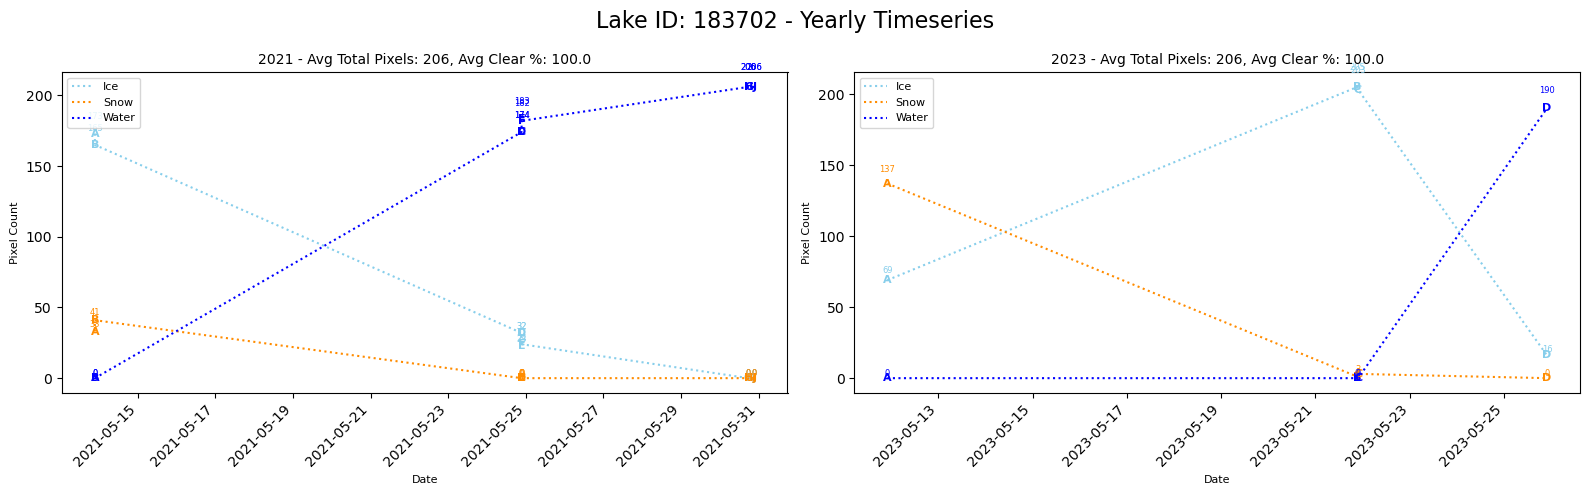

In [29]:

# Set paths
netcdf_path = r"D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\lake_statistics.nc"
base_image_folder = r"D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\Downsampled RGBs"

plot_lake_timeseries_yearly(183702, netcdf_path, base_image_folder)

Processing images: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


GIF saved to D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\Visualization GIFs\lake_174156_2021_timelapse.gif


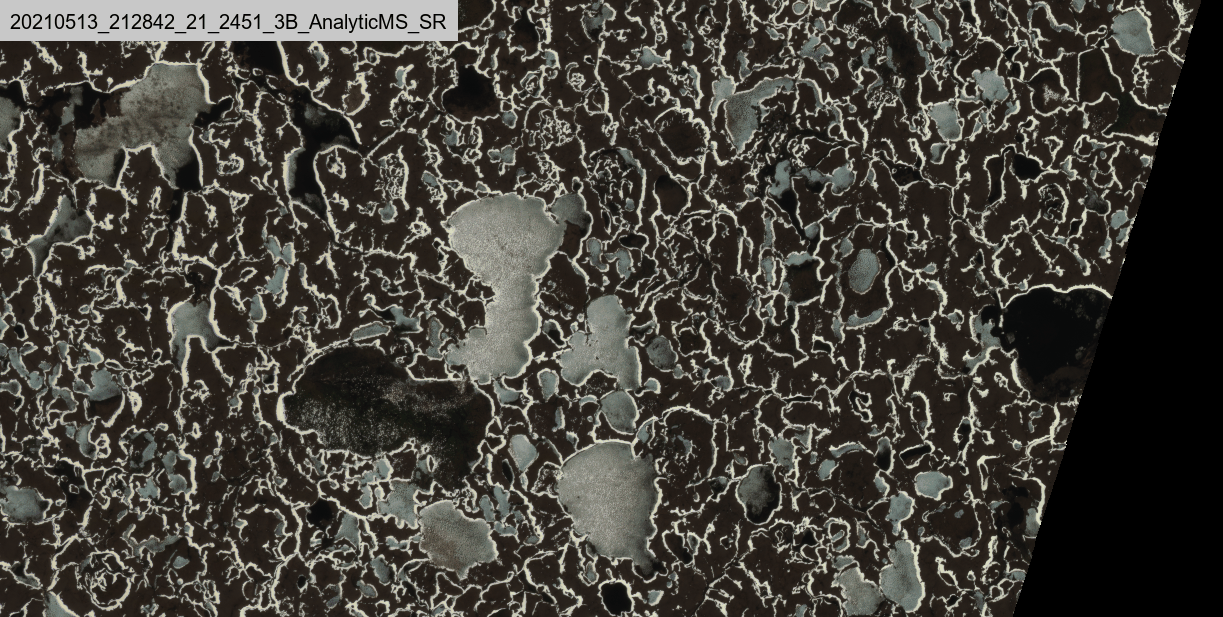

In [16]:
import os
import glob
import numpy as np
import rasterio
import imageio
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import netCDF4 as nc
import rasterio.merge
import rasterio.mask
from shapely.geometry import box
from IPython.display import Image as IPythonImage, display

def find_image_paths(base_dir, prefixes):
    """
    Find full paths for image files matching given prefixes.
    
    Args:
        base_dir (str): Base directory to search for images
        prefixes (list): List of image prefixes to match
    
    Returns:
        list: Sorted list of full paths to matching image files
    """
    matching_images = []
    
    for prefix in prefixes:
        search_pattern = os.path.join(base_dir, '**', f'{prefix}.tif')
        matches = glob.glob(search_pattern, recursive=True)
        
        if matches:
            matching_images.extend(matches)
        else:
            print(f"Warning: No image found for prefix {prefix}")
    
    # Sort images to ensure chronological order
    return sorted(matching_images)

def find_common_overlap(image_paths):
    """
    Find the common geographic overlap of multiple images.
    
    Args:
        image_paths (list): List of image file paths
    
    Returns:
        tuple: Bounding box coordinates (left, bottom, right, top)
    """
    # Collect bounds of all images
    bounds_list = []
    
    for path in image_paths:
        with rasterio.open(path) as src:
            # Get the bounds in the coordinate system of the raster
            bounds = src.bounds
            bounds_list.append(bounds)
    
    # Find the intersection of all bounds
    left = max(bound.left for bound in bounds_list)
    bottom = max(bound.bottom for bound in bounds_list)
    right = min(bound.right for bound in bounds_list)
    top = min(bound.top for bound in bounds_list)
    
    return (left, bottom, right, top)

def process_image(image_path, bounds, downsample_factor=4, title=None):
    """
    Read, crop, and process a geotiff image.
    
    Args:
        image_path (str): Path to the geotiff image
        bounds (tuple): Geographic bounds to crop to
        downsample_factor (int): Factor by which to reduce image size
        title (str, optional): Title to add to the image
    
    Returns:
        numpy.ndarray: Processed image array
    """
    with rasterio.open(image_path) as src:
        # Crop to the common bounds
        out_image, out_transform = rasterio.mask.mask(
            src, 
            [box(*bounds)], 
            crop=True, 
            nodata=0
        )
        
        # Reorder bands from BGR NIR to RGB
        # Assuming bands are in order: Blue (1), Green (2), Red (3), NIR (4)
        rgb_bands = out_image[[2, 1, 0]]  # Red, Green, Blue
        
        # Downsample
        downsampled_image = rgb_bands[:, ::downsample_factor, ::downsample_factor]
        
        # Transpose to (height, width, channels)
        downsampled_image = np.transpose(downsampled_image, (1, 2, 0))
        
        # Normalize to 0-255 range
        downsampled_image = ((downsampled_image - downsampled_image.min()) / 
                             (downsampled_image.max() - downsampled_image.min()) * 255).astype(np.uint8)
        
        # Add title if provided
        if title:
            pil_image = Image.fromarray(downsampled_image)
            draw = ImageDraw.Draw(pil_image)
            
            # Try to load a font, fallback to default
            try:
                font = ImageFont.truetype("arial.ttf", 20)
            except IOError:
                font = ImageFont.load_default()
            
            # Add title with a semi-transparent background
            text_bbox = draw.textbbox((0, 0), title, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Background rectangle
            draw.rectangle([0, 0, text_width + 20, text_height + 20], 
                           fill=(200, 200, 200, 128))
            
            # Text
            draw.text((10, 10), title, font=font, fill=(0, 0, 0))
            
            downsampled_image = np.array(pil_image)
        
        return downsampled_image

def generate_lake_gif(netcdf_path, lake_id, base_dir, output_dir, year=2021, downsample_factor=4, display_gif=True):
    """
    Generate a GIF of lake images for a specific year.
    
    Args:
        netcdf_path (str): Path to the NetCDF file
        lake_id (int): Lake ID to process
        base_dir (str): Base directory to search for images
        output_dir (str): Directory to save output GIF
        year (int): Year to filter images
        downsample_factor (int): Factor to downsample images
        display_gif (bool): Whether to display the GIF in Jupyter
    
    Returns:
        str: Path to the generated GIF
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Get image prefixes
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        lake_ids = ncfile.variables['lake_id'][:]
        try:
            lake_index = np.where(lake_ids == lake_id)[0][0]
        except IndexError:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return None
        
        # Extract prefixes for this lake
        prefixes = ncfile.variables['prefixes'][lake_index]
        prefixes = [prefix for prefix in prefixes if isinstance(prefix, str)]
    
    # Filter prefixes for the specified year
    year_prefixes = [p for p in prefixes if p.startswith(str(year))]
    
    # Find image paths
    image_paths = find_image_paths(base_dir, year_prefixes)
    
    if not image_paths:
        print(f"No images found for Lake ID {lake_id} in year {year}")
        return None
    
    # Find common geographic overlap
    common_bounds = find_common_overlap(image_paths)
    
    # Prepare images for GIF
    images = []
    
    for path in tqdm(image_paths, desc="Processing images"):
        try:
            # Extract filename as title
            title = os.path.splitext(os.path.basename(path))[0]
            
            # Process image with common bounds, band reordering, and title
            processed_image = process_image(path, common_bounds, 
                                            downsample_factor, 
                                            title=title)
            images.append(processed_image)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    
    # Create GIF
    if images:
        output_path = os.path.join(output_dir, f'lake_{lake_id}_{year}_timelapse.gif')
        imageio.mimsave(output_path, images, fps=2)
        print(f"GIF saved to {output_path}")
        
        # Display in Jupyter if requested
        if display_gif:
            display(IPythonImage(filename=output_path))
        
        return output_path
    else:
        print("No images could be processed.")
        return None
    
def get_lake_image_prefixes(netcdf_path, lake_id):
    # Open the NetCDF file
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        # Get all lake IDs
        lake_ids = ncfile.variables['lake_id'][:]
        
        # Find the index of the specified lake
        try:
            lake_index = np.where(lake_ids == lake_id)[0][0]
        except IndexError:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return []
        
        # Extract prefixes for this lake
        prefixes = ncfile.variables['prefixes'][lake_index]
        
        # Remove any NaN or null values
        prefixes = [prefix for prefix in prefixes if isinstance(prefix, str)]
        
        return prefixes

if __name__ == "__main__":

    base_dir = r'D:\planetscope_lake_ice\Data (Unclassified)\1 - Break Up Time Series Input'
    output_dir = r'D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\Visualization GIFs'
    
    get_lake_image_prefixes(netcdf_path, lake_id)
    generate_lake_gif(netcdf_path, lake_id, base_dir, output_dir, year=2021)

Processing images: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

GIF saved to D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\Visualization GIFs\lake_674813_2023_timelapse.gif


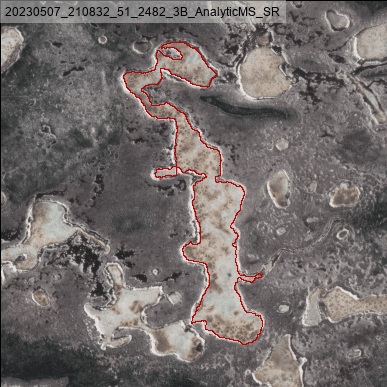

In [ ]:
import os
import glob
import numpy as np
import rasterio
import imageio
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import netCDF4 as nc
import rasterio.mask
from shapely.geometry import box
import geopandas as gpd
from pyproj import Transformer

def find_image_paths(base_dir, prefixes):
    """Find full paths for image files matching given prefixes."""
    matching_images = []
    
    for prefix in prefixes:
        search_pattern = os.path.join(base_dir, '**', f'{prefix}.tif')
        matches = glob.glob(search_pattern, recursive=True)
        
        if matches:
            matching_images.extend(matches)
        else:
            print(f"Warning: No image found for prefix {prefix}")
    
    return sorted(matching_images)

def get_lake_polygon(shapefile_path, lake_id):
    """Retrieve the polygon and CRS for a specific lake from a shapefile."""
    gdf = gpd.read_file(shapefile_path)
    lake_row = gdf[gdf['id'] == lake_id]
    
    if len(lake_row) == 0:
        print(f"No lake found with ID {lake_id}")
        return None, None
    
    return lake_row.geometry.iloc[0], lake_row.crs

def create_lake_bounds(lake_polygon, polygon_crs, src_crs):
    """
    Create a bounding box for the lake, transformed to the source CRS.
    
    Args:
        lake_polygon (shapely.geometry.Polygon): Lake polygon
        polygon_crs (pyproj.CRS): CRS of the original polygon
        src_crs (pyproj.CRS): Target CRS to transform to
    
    Returns:
        tuple: Bounding box coordinates (left, bottom, right, top)
    """
    # Create transformer
    transformer = Transformer.from_crs(polygon_crs, src_crs, always_xy=True)
    
    # Transform polygon coordinates
    transformed_coords = []
    for x, y in lake_polygon.exterior.coords:
        transformed_x, transformed_y = transformer.transform(x, y)
        transformed_coords.append((transformed_x, transformed_y))
    
    # Create a new polygon with transformed coordinates
    transformed_polygon = gpd.GeoSeries([shapely.geometry.Polygon(transformed_coords)], crs=src_crs)[0]
    
    # Get the geographic bounds
    left, bottom, right, top = transformed_polygon.bounds
    
    # Calculate the current width and height
    width = right - left
    height = top - bottom
    
    # Add 500m to sides 
    left -= 500
    right += 500
    bottom -= 500
    top += 500
    
    # Make it a square by taking the larger dimension
    square_size = max(right - left, top - bottom)
    
    # Center the square on the original bounds
    center_x = (left + right) / 2
    center_y = (bottom + top) / 2
    
    half_square = square_size / 2
    
    # Adjust bounds to create a square
    left = center_x - half_square
    right = center_x + half_square
    bottom = center_y - half_square
    top = center_y + half_square
    
    return (left, bottom, right, top)

def process_image(image_path, lake_bounds, lake_polygon=None, polygon_crs=None, downsample_factor=4, title=None):
    """
    Read, crop, and process a geotiff image with lake polygon overlay.
    
    Args:
        image_path (str): Path to the geotiff image
        lake_bounds (tuple): Bounding box for lake area
        lake_polygon (shapely.geometry.Polygon, optional): Lake polygon to overlay
        polygon_crs (pyproj.CRS, optional): CRS of the lake polygon
        downsample_factor (int): Factor by which to reduce image size
        title (str, optional): Title to add to the image
    
    Returns:
        numpy.ndarray: Processed image array
    """
    with rasterio.open(image_path) as src:
        # Crop to the lake bounds
        out_image, out_transform = rasterio.mask.mask(
            src, 
            [box(*lake_bounds)], 
            crop=True, 
            nodata=0
        )
        
        # Reorder bands from BGR NIR to RGB
        rgb_bands = out_image[[2, 1, 0]]  # Red, Green, Blue
        
        # Downsample
        downsampled_image = rgb_bands[:, ::downsample_factor, ::downsample_factor]
        
        # Transpose to (height, width, channels)
        downsampled_image = np.transpose(downsampled_image, (1, 2, 0))
        
        # Normalize to 0-255 range
        downsampled_image = ((downsampled_image - downsampled_image.min()) / 
                             (downsampled_image.max() - downsampled_image.min()) * 255).astype(np.uint8)
        
        # Convert to PIL Image for further processing
        pil_image = Image.fromarray(downsampled_image)
        draw = ImageDraw.Draw(pil_image, 'RGBA')
        
        # Overlay lake polygon if provided
        if lake_polygon is not None and polygon_crs is not None:
            try:
                # Transform polygon to image coordinates using the lake bounds transform
                transformer = Transformer.from_crs(polygon_crs, src.crs, always_xy=True)
                
                # Transform polygon coordinates
                transformed_coords = []
                for x, y in lake_polygon.exterior.coords:
                    # Transform geographic coordinates
                    transformed_x, transformed_y = transformer.transform(x, y)
                    
                    # Convert to pixel coordinates relative to the cropped image
                    pixel_x, pixel_y = ~out_transform * (transformed_x, transformed_y)
                    
                    # Downsample the coordinates
                    transformed_coords.append((
                        int(pixel_x / downsample_factor), 
                        int(pixel_y / downsample_factor)
                    ))
                
                # Darker, less saturated red with lower opacity
                red_outline_colors = [
                    (180, 0, 0, 200),  # Outer line - darker, less opaque
                    (180, 0, 0, 0),    # Middle line completely clear
                    (180, 0, 0, 200)   # Inner line - darker, less opaque
                ]
                
                # Draw thinner outlines
                for thickness, color in zip(range(3, 0, -1), red_outline_colors):
                    draw.polygon(transformed_coords, 
                                 outline=(*color[:3], color[3]), 
                                 fill=None)
                
            except Exception as e:
                print(f"Error transforming polygon: {e}")
        
        # Add title if provided
        if title:
            try:
                font = ImageFont.truetype("arial.ttf", 12)  # Reduced font size
            except IOError:
                font = ImageFont.load_default()
            
            # Add title with a semi-transparent background
            text_bbox = draw.textbbox((0, 0), title, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            draw.rectangle([0, 0, text_width + 10, text_height + 10], 
                           fill=(200, 200, 200, 128))
            
            draw.text((5, 5), title, font=font, fill=(0, 0, 0))
        
        return np.array(pil_image)

def generate_lake_gif(netcdf_path, lake_id, base_dir, output_dir, shapefile_path, year=2021, downsample_factor=4, display_gif=True):
    """
    Generate a GIF of lake images for a specific year with lake-centered zoom.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Get lake polygon and its CRS
    lake_polygon, polygon_crs = get_lake_polygon(shapefile_path, lake_id)
    
    if lake_polygon is None:
        print(f"Could not find polygon for Lake ID {lake_id}")
        return None
    
    # Get image prefixes
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        lake_ids = ncfile.variables['lake_id'][:]
        try:
            lake_index = np.where(lake_ids == lake_id)[0][0]
        except IndexError:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return None
        
        # Extract prefixes for this lake
        prefixes = ncfile.variables['prefixes'][lake_index]
        prefixes = [prefix for prefix in prefixes if isinstance(prefix, str)]
    
    # Filter prefixes for the specified year
    year_prefixes = [p for p in prefixes if p.startswith(str(year))]
    
    # Find image paths and sort chronologically
    image_paths = find_image_paths(base_dir, year_prefixes)
    
    if not image_paths:
        print(f"No images found for Lake ID {lake_id} in year {year}")
        return None
    
    # Sort image paths chronologically
    image_paths.sort()
    
    # Prepare images for GIF
    images = []
    
    # Use the first image to get CRS for lake bounds
    with rasterio.open(image_paths[0]) as first_src:
        lake_bounds = create_lake_bounds(lake_polygon, polygon_crs, first_src.crs)
    
    for i, path in enumerate(tqdm(image_paths, desc="Processing images")):
        try:
            # Extract filename as title
            filename = os.path.splitext(os.path.basename(path))[0]
            
            # Add alphabetic label
            label = chr(65 + i)  # A, B, C, etc.
            title = f"{label}: {filename}"
            
            # Process image with lake bounds, polygon overlay, and title
            processed_image = process_image(path, lake_bounds, 
                                            lake_polygon=lake_polygon,
                                            polygon_crs=polygon_crs,
                                            downsample_factor=downsample_factor, 
                                            title=title)
            images.append(processed_image)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    
    # Create GIF
    if images:
        output_path = os.path.join(output_dir, f'lake_{lake_id}_{year}_timelapse.gif')
        imageio.mimsave(output_path, images, fps=2)
        print(f"GIF saved to {output_path}")
        
        # Display in Jupyter if requested
        if display_gif:
            display(IPythonImage(filename=output_path))
        
        return output_path
    else:
        print("No images could be processed.")
        return None

# Example usage in __main__
if __name__ == "__main__":
    base_dir = r'D:\planetscope_lake_ice\Data (Unclassified)\1 - Break Up Time Series Input'
    output_dir = r'D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\Visualization GIFs'
    shapefile_path = r'D:\planetscope_lake_ice\Data (Validation)\8 - Download ALPOD data here\ALPODlakes.shp'
    lake_id = 674813  # Replace with your specific lake ID
    
    generate_lake_gif(netcdf_path, lake_id, base_dir, output_dir, shapefile_path, year=2023)